In [1]:
from efficientnet_pytorch import EfficientNet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b5')

In [5]:
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

456

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b5


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
np.random.seed(42)


In [10]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [11]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [12]:
bs=8

In [13]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

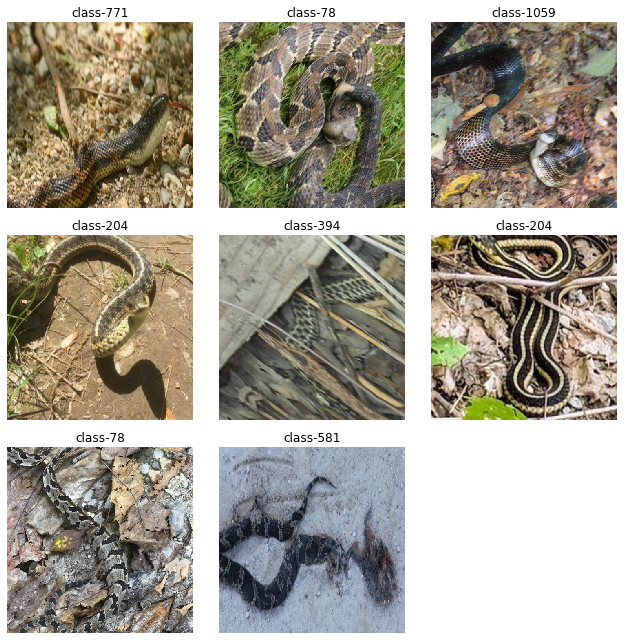

In [14]:
data.show_batch(3,figsize=(9,9))

In [15]:
list(children(model))[-2:]


[BatchNorm2d(2048, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [17]:
ef_head = create_head(2048, data.c, concat_pool=False)
ef_head = nn.Sequential(*(list(ef_head.children())[3:]))

In [18]:
model.add_module('_fc',nn.Linear(2048, data.c))
# model.add_module('_fc',ef_head)

In [19]:
loss_func =LabelSmoothingCrossEntropy()


In [20]:
RMSprop = partial(torch.optim.RMSprop,momentum=0.9)


In [21]:
from torch.optim import Optimizer

In [22]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')],wd=1e-5)


In [23]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [24]:
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [25]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:19]],
             [learn.model._blocks[19:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [26]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 457, 457]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 230, 230]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 228, 228]       0          False     
_________________________________________________

In [27]:
learn.load('b7-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


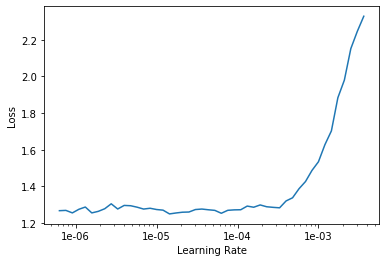

In [30]:
learn.recorder.plot()

In [31]:
learn.validate()

[1.2648666, tensor(0.8226), tensor(0.7907)]

In [32]:
lr = 5e-5

In [33]:
learn.fit_one_cycle(2,slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.195712,1.234017,0.831948,0.797582,48:13
1,1.248137,1.216687,0.836559,0.801701,48:21


In [34]:
from fastai.metrics import accuracy, top_k_accuracy

top_2_accuracy = partial(top_k_accuracy, k=2)

In [37]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

In [38]:
learn.validate()

[1.2166868, tensor(0.8366), tensor(0.9137)]

In [39]:
learn.save('b7-round-2')

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


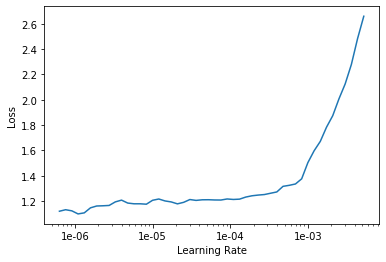

In [41]:
learn.recorder.plot()

In [42]:
lr = 1e-7

In [44]:
learn.load('b7-round-2')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [45]:
interp = ClassificationInterpretation.from_learner(learn)


In [46]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

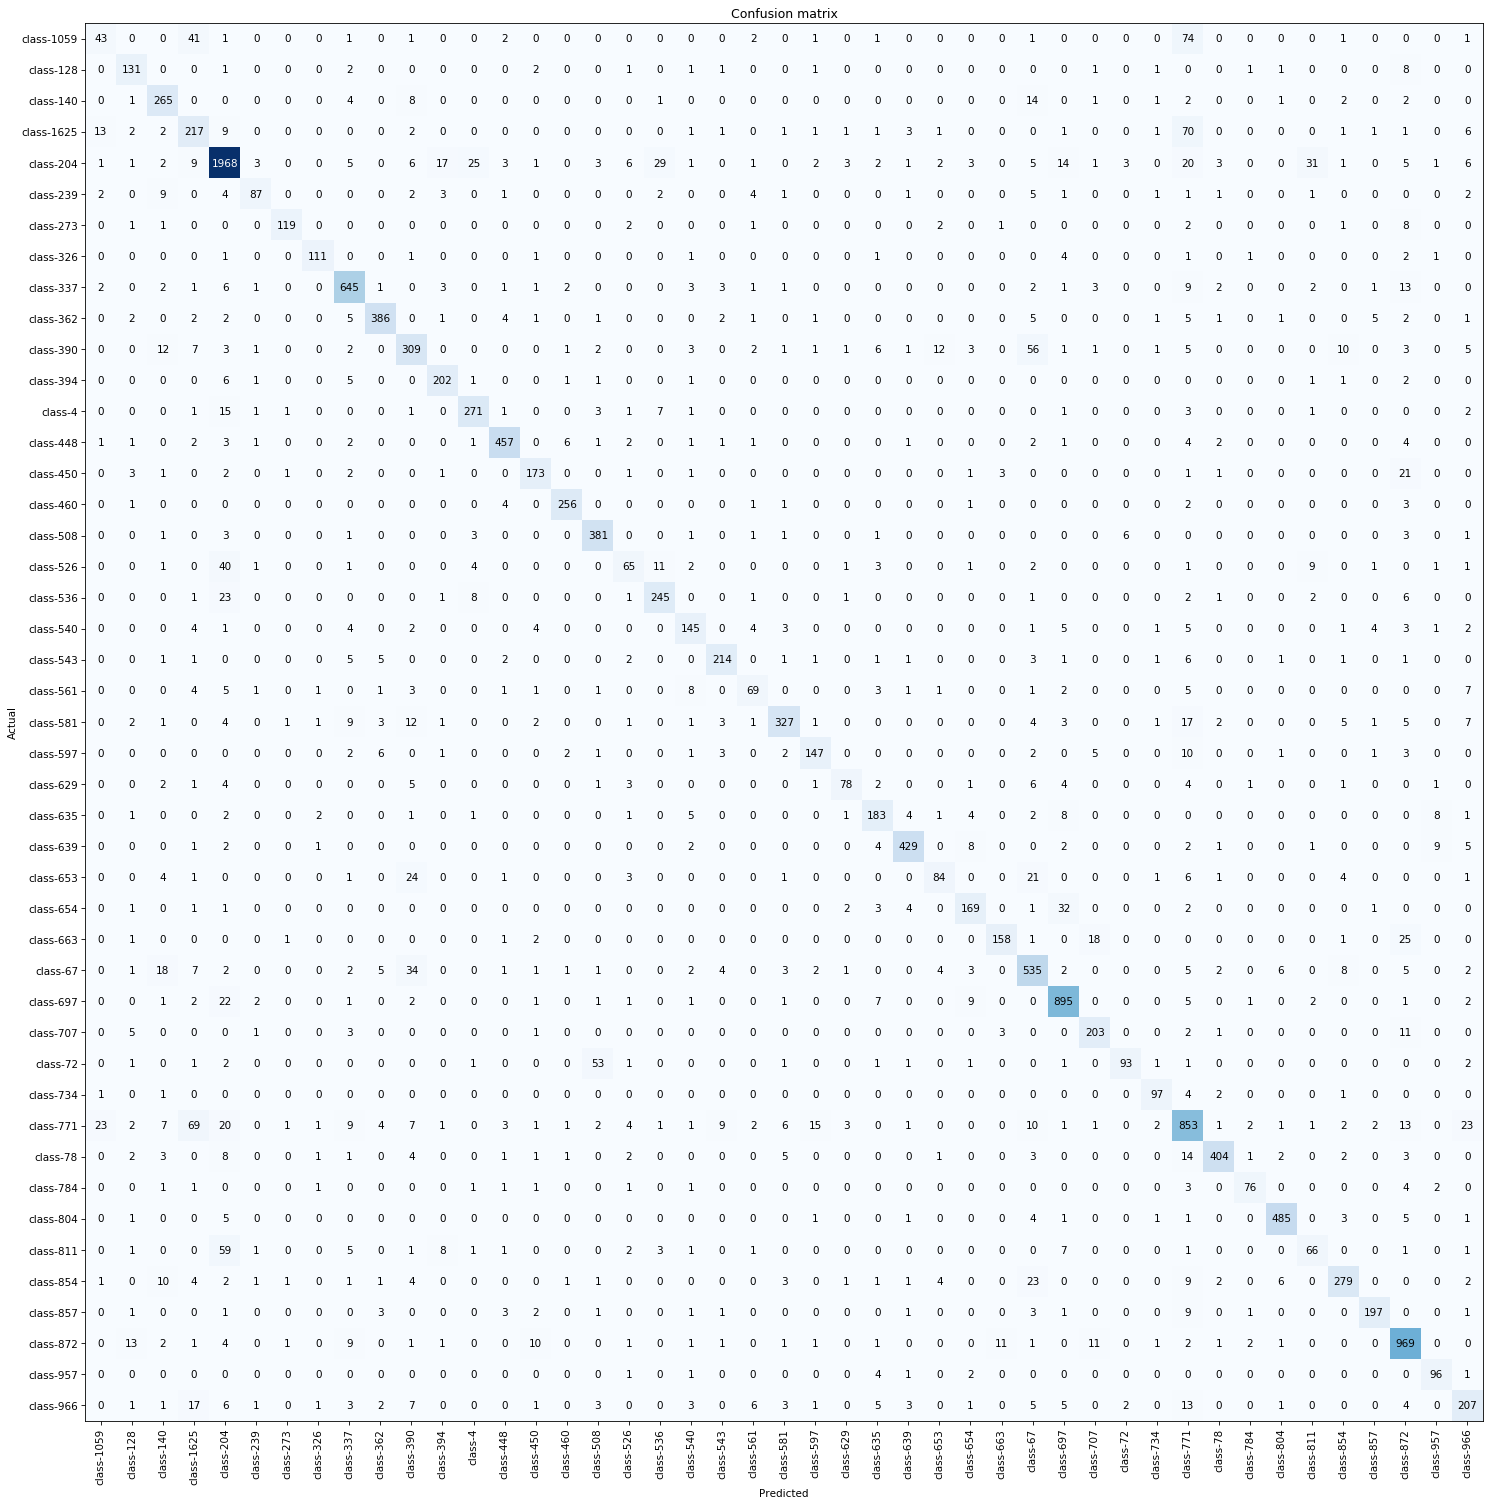

In [47]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75)


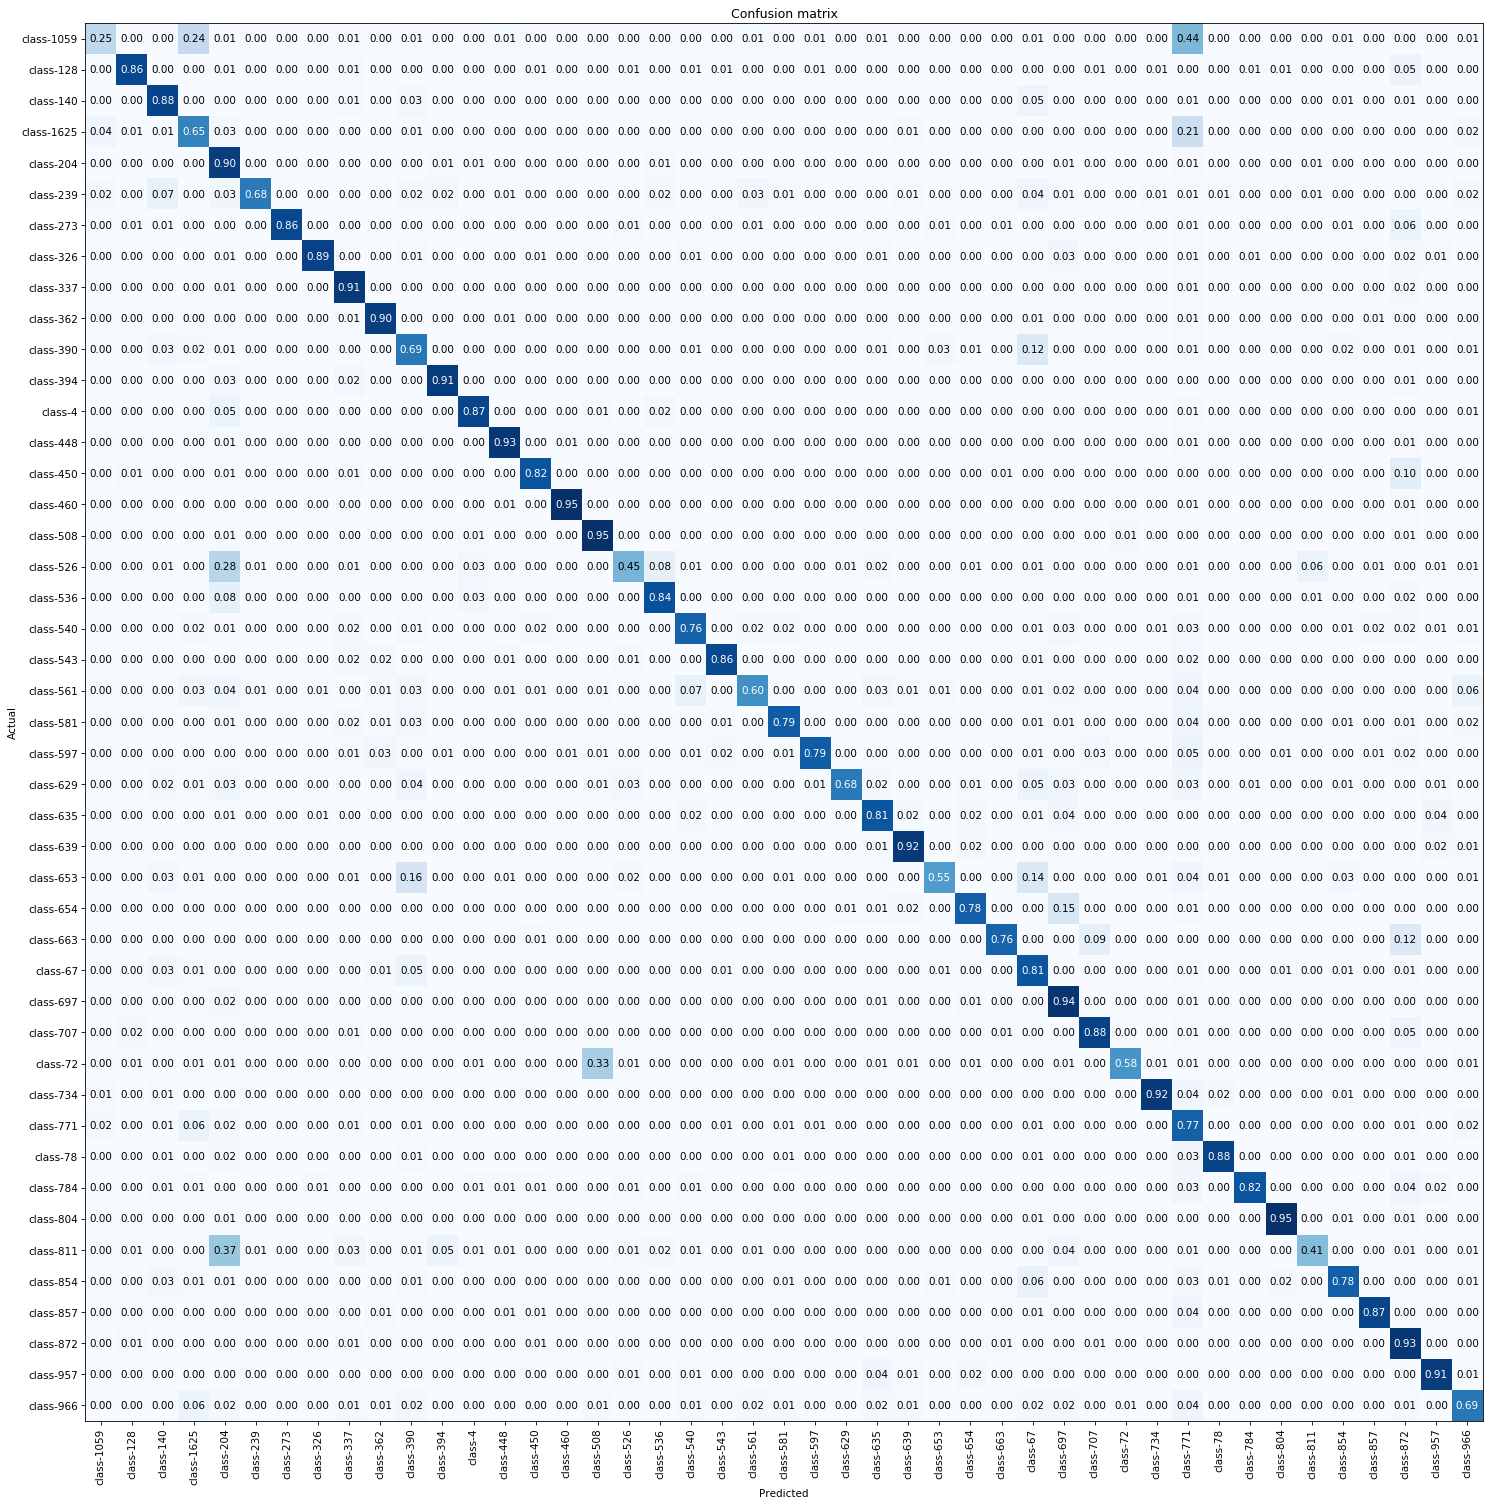

In [48]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


In [49]:
preds,_ = learn.TTA(ds_type=DatasetType.Valid)

In [55]:
preds.shape

torch.Size([16483, 45])

In [56]:
y_true = data.valid_ds.y.items

In [57]:
y_true

array([19, 33, 35, 12, ..., 22, 11, 29, 22])

In [96]:
probs = np.exp(preds) / np.exp(preds).sum(1)[:,None]

In [97]:
probs_np = probs.numpy()

In [98]:
y_pred = []

In [84]:
result = np.where(data.classes == 'class-4')

In [87]:
result

(array([], dtype=int64),)

In [99]:
len(y_true)

16483

In [ ]:
count=0

In [111]:
for i in range(0,45):
    print(str(i)+" "+data.classes[i])

0 class-1059
1 class-128
2 class-140
3 class-1625
4 class-204
5 class-239
6 class-273
7 class-326
8 class-337
9 class-362
10 class-390
11 class-394
12 class-4
13 class-448
14 class-450
15 class-460
16 class-508
17 class-526
18 class-536
19 class-540
20 class-543
21 class-561
22 class-581
23 class-597
24 class-629
25 class-635
26 class-639
27 class-653
28 class-654
29 class-663
30 class-67
31 class-697
32 class-707
33 class-72
34 class-734
35 class-771
36 class-78
37 class-784
38 class-804
39 class-811
40 class-854
41 class-857
42 class-872
43 class-957
44 class-966


In [184]:
learn=None
learn=gc.collect()

In [175]:
count=0
y_pred=[]
for i in range(0,len(y_true)):
    temp = probs_np[i,:]
    max_temp =np.argmax(temp)
    if (max_temp == 3):
        if (temp[3]-temp[0])<0.1:
            y_pred.append(0)
        else:
            y_pred.append(3)
    else:
        if (max_temp == 35):
            print(str(temp[35])+" "+str(temp[0]))
            if (temp[35]-temp[0])<0.1:
                y_pred.append(0)
                count+=1
            else:
                y_pred.append(35)
            
        else:
            y_pred.append(max_temp)
    


0.55812126 0.1869128
0.42830682 0.22901519
0.4116076 0.18768418
0.80105746 0.0075064334
0.9009128 0.016065346
0.7184925 0.109020546
0.7794905 0.07463564
0.4331167 0.051546566
0.24782024 0.14498344
0.96703535 0.0024086062
0.33629432 0.0028708824
0.4353915 0.035881266
0.44447666 0.005530671
0.31661046 0.10917433
0.36580473 0.053397994
0.89802134 0.015305758
0.22688569 0.06821358
0.8352012 0.007909704
0.71318173 0.19098477
0.6594671 0.15407573
0.4764908 0.09660957
0.90588856 0.011139479
0.32096958 0.019210683
0.61766845 0.13550822
0.31779364 0.0029338363
0.25093365 0.05425942
0.74580115 0.07216581
0.5789301 0.029975526
0.9440816 0.019188222
0.75857127 0.023393102
0.33596745 0.16874054
0.9312124 0.0059709637
0.94164264 0.010743799
0.7609155 0.010620174
0.21310164 0.0024271265
0.6276599 0.11200402
0.6295226 0.088789344
0.75504893 0.0007903853
0.9452414 0.0031770575
0.19880697 0.042200908
0.69430137 0.18018289
0.3263589 0.09214862
0.90991133 0.0011625729
0.61036825 0.1618205
0.6528052 0.0428

In [176]:
count

49

In [177]:
len(y_pred),len(y_true)

(16483, 16483)

In [178]:
import sklearn.metrics


In [179]:
sklearn.metrics.accuracy_score(y_true,y_pred)

0.8431717527149184

In [180]:
sklearn.metrics.f1_score(y_true,y_pred,average='macro')

0.812325128145168

In [149]:
import numpy
numpy.savetxt("y_probs.csv", probs_np, delimiter=",")

In [82]:
learn.save('best')